# NLP Disaster Tweets

## Problem and Data

In this competition we will be using Natural Language Processing (NLP) to predict whether a tweet is about a real disaster. Natural Language Processing gives us an opportunity to analyze large amounts of natural language data, and specifically for this project, to make predictions based on that language data. The competition can be found here: https://www.kaggle.com/c/nlp-getting-started/overview

First lets make all the necessary imports for this competition, get the related files, and take a quick look at the data before analyzing it further.

In [579]:
import random

In [580]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [581]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data  = pd.read_csv('../input/nlp-getting-started/test.csv')

In [582]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [583]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [584]:
print("Training Data")
print("Row Count: ", str(train_data.shape[0]))
print("Column Count: " + str(train_data.shape[1]))

Training Data
Row Count:  7613
Column Count: 5


In [585]:
print("Test Data")
print("Row Count: ", str(test_data.shape[0]))
print("Column Count: " + str(test_data.shape[1]))

Test Data
Row Count:  3263
Column Count: 4


In [586]:
train_data.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Exploratory Data Analysis

In [587]:
train_data['text'][random.randint(0, 7613)]

'???? it was an accident http://t.co/Oia5fxi4gM'

Now we've analyzed what the data looks like and we know we have 7613 rows in the training set with 5 columns. We also can look at random tweets in the data set by running the code block above.

Next it's time to get a better look at the tweet text that we have. We also want to take a better look at the tweets so we can get a better idea of frequency of certain words used. I also want to get a better look at the location and keyword data because maybe either of those will be a strong predictor or at the very least we can find something interesting from them.

### Location

First let's take a look at the location column.

In [588]:
train_data['location'].nunique()

3341

In [589]:
test_data['location'].nunique()

1602

In [590]:
for location in train_data['location'].unique()[:20]:
    print(location)

nan
Birmingham
Est. September 2012 - Bristol
AFRICA
Philadelphia, PA
London, UK
Pretoria
World Wide!!
Paranaque City
Live On Webcam
milky way
GREENSBORO,NORTH CAROLINA
England.
Sheffield Township, Ohio
India
Barbados
Anaheim
Abuja
USA
South Africa


Looking at 20 of the location entrys, we see that we have a mixed bag. Some are kind of nonsensical like World Wide!!! while other give a specific location like Sheffield Township, and others give broad locations like South Africa.

We also see that we have a similar distribution of unique location values to rows in both the test and train datasets.

At this stage I'm wondering if all of these values occur once, or if some are repeating so let's see how many have a value count above 1.

In [591]:
duplicate_count = (train_data['location'].value_counts() > 1).sum()
print(duplicate_count)

523


So there are actually a lot that occur more than once, let's print some examples below.

In [592]:
duplicates = train_data['location'].value_counts()
duplicates = duplicates[duplicates > 1]
print(duplicates.head(20))

location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: count, dtype: int64


Now lets create a simple but maybe excessive function that fills the null values with "None" for location that we can resuse later if needed.

In [593]:
def fill_location(df):
    df['location'] = df['location'].fillna("no_location")

In [594]:
fill_location(train_data)

In [595]:
fill_location(test_data)

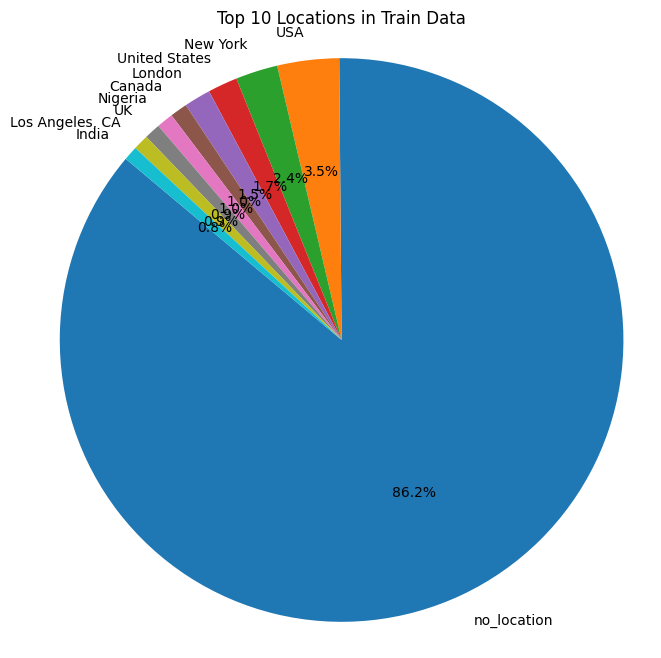

In [596]:
import matplotlib.pyplot as plt
location_counts = train_data['location'].value_counts().head(10)
plt.figure(figsize=(8, 8))
plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Locations in Train Data')
plt.axis('equal')
plt.show()

### Keyword

Lets do something similar for the keyword column.

In [597]:
train_data['location'].nunique()

3342

In [598]:
test_data['keyword'].nunique()

221

In [599]:
duplicates = train_data['keyword'].value_counts()
duplicates = duplicates[duplicates > 1]
print(duplicates.head(20))

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64


We see a much different distribution here than we did for location, lets take a look at the number of null values.

In [ ]:
train_data['keyword'].isna().sum()


61

Wow, only 61 null values here. Let's create a graph to visualize the distribution of words to see if its as even as it looks across the board. We don't have to care about specific words in this case.

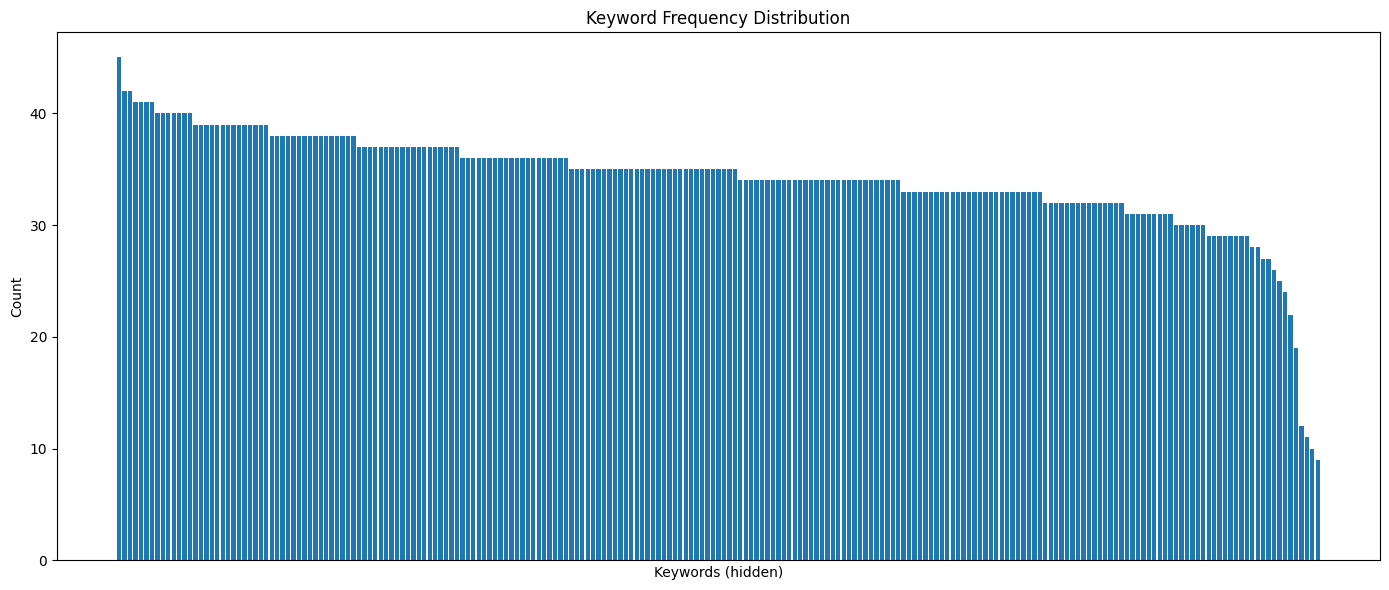

In [601]:
import matplotlib.pyplot as plt

# Get value counts
keyword_counts = train_data['keyword'].value_counts()

plt.figure(figsize=(14, 6))
plt.bar(range(len(keyword_counts)), keyword_counts.values)

plt.title('Keyword Frequency Distribution')
plt.xlabel('Keywords (hidden)')
plt.ylabel('Count')
plt.xticks([])
plt.tight_layout()
plt.show()

So we do see a pretty even distribution of word frequency here. Now let's just do the same thing we did for location and fill the NA values with no_keyword

In [602]:
def fill_keyword(df):
    df['keyword'] = df['keyword'].fillna("no_keyword")

In [603]:
fill_keyword(train_data)
fill_keyword(test_data)

In [604]:
train_data['keyword'].isna().sum()

0

### Text

Now for probably the most interesting part let's analyze the actual text of the tweets. We will start by graphing the distribution of the lengths of the tweets for both the train and test sets.

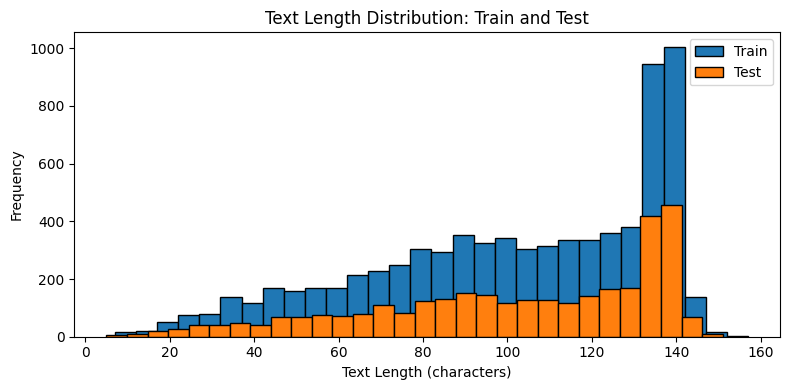

In [605]:
train_lengths = train_data['text'].str.len()
test_lengths = test_data['text'].str.len()

plt.figure(figsize=(8, 4))
plt.hist(train_lengths, bins=30, label='Train', edgecolor='black')
plt.hist(test_lengths, bins=30, label='Test', edgecolor='black')
plt.title('Text Length Distribution: Train and Test')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

So we see both of them have a similar distribution of text length.

Let's take a closer look at some random tweets so we have an idea of ways we can clean them if needed.

In [606]:
for _ in range(10):
    print(train_data['text'][random.randint(0, 7613)])

US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability
@stfxuniversity For the people who died in Human Experiments by Unit 731 of Japanese military http://t.co/vVPLFQv58P http://t.co/l5AWTUndhm
Wildfire Burns On California U.s. China Economic Net Û_ : http://t.co/U2dO2mC2ri  http://t.co/3oM3xw6CZ8
Plane debris is from missing MH370 http://t.co/kxy56FR8vM
LIKE I SWEAR THE SECRET WE'LL UNCOVER IS THE OLD GODS IN A SLUMBER. I THINK THERES GONNA BE ANOTHER BLIGHT
What's happening? A destruction indeed http://t.co/tUX0YPwZuR
@BLutz10 But the rioting began prior to the decision for the indictment so you're not really making sense at this pointÛ_
babe I'm gonna ruin you if you let me stay
I'm battling monsters I'm pulling you out of the burning buildings and you say I'll give you anything but you never come through.
Photo: Beach Earrings Beach Jewelry Vacation Earrings Keep Calm and Beach On Earrings Made w

We will take a look at the @'s to see if some are to weather service

In [607]:
import re

# Extract all URLs from the text column
all_urls = train_data['text'].str.extractall(r'(http[s]?://\S+)')[0]

# Get value counts
url_counts = all_urls.value_counts()

# Show top 10 most common URLs
print(url_counts.head(50))

0
http://t.co/qew4c5M1xd     9
http://t.co/KSAwlYuX02     6
http://t.co/q2eBlOKeVE     6
http://t.co/eNCmhz6y34     6
http://t.co/cybKsXHF7d     5
http://t.co/vVPLFQv58P     5
https://t.co/moLL5vd8yD    4
http://t.co/zujwUiomb3     4
http://t.co/WvJ39a3BGM     4
http://t.co/thoYhrHkfJ     4
http://t.co/vIwXY1XDYK     4
https://t.co/rqWuoy1fm4    4
http://t.co/o91f3cYy0R     4
http://t.co/nnMQlz91o9     4
http://t.co/LvlH3W3aWO     4
http://t.co/cEdCUgEuWs     3
http://t.co/BbDpnj8XSx     3
http://t.co/9NwAJLi9cr     3
http://t.co/0wrATkA2jL     3
http://t.co/V3aZWOAmzK     3
https://t.co/e8dl1lNCVu    3
https://t.co/dehMym5lpk    3
http://t.co/THyzOMVWU0     2
http://t.co/J5mKcbKcov     2
http://t.co/M5KxLPKFA1     2
http://t.co/SQsyUeh4yI     2
http://t.co/EDyfo6E2PU     2
http://t.co/sDgOUtWNtb     2
http://t.co/iIkSsJGBDn     2
http://t.co/zEVakJaPcz     2
http://t.co/vAM5POdGyw     2
http://t.co/83jOO0xk29     2
http://t.co/btdjGWeKqx     2
http://t.co/7hAnPcr5rK     2
http://t.co/

In [608]:
# Count how many URLs appear only once
unique_url_count = (url_counts >= 2).sum()
print(unique_url_count)

73


We see there are obviously a couple urls that are repeated, but not many are repeated frequently and most are unique. I will just remove them from the dataset for simplicity.

In [609]:
import re

def remove_urls(df):
    url_pattern = r'http[s]?://\S+'
    df['text'] = df['text'].str.replace(url_pattern, '', regex=True)
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [611]:
test_url_df = pd.DataFrame({
    'text': [
        "Check this out: http://example.com",
        "No link here just some text",
        "Multiple links http://a.com and https://b.org/page",
        "Trailing space after link https://test.com ",
        "Link in the middle http://mid.com of sentence"
    ]
})

# Run your function
remove_urls(test_url_df)

# Display the cleaned DataFrame
print(test_url_df)

                             text
0                 Check this out:
1     No link here just some text
2              Multiple links and
3       Trailing space after link
4  Link in the middle of sentence


In [612]:
remove_urls(train_data)
remove_urls(test_data)

In [613]:
for _ in range(10):
    print(train_data['text'][random.randint(0, 7613)])

New technology designed to help prevent dangerous police chases: In an effort to reduce injuries Milwaukee policeÛ_
MP train derailment: Village youth saved many lives #IndiaTV
@ArianaGrande @justinbieber I'M SCREAMING OMG #IDOLS #22DAYS #WDYM
E-Mini SP 500: Earnings letdown equals market meltdown! #Amazon
susinesses are deluged with invoices. Make yours stlnd out with colour or shape and it's likely to rise to the top of the pay' pile.
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time
family members of osama bin laden have died in an airplane accident how ironic ?????? mhmmm gov shit i suspect
Top link: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined
Businesses are|deluged with invoices. Make y urs stand out with colour or shape and it's likely to rise to the top of the pay' pile.
Mike Magner Discusses A Trust Betrayed: via @YouTube #military #veterans #environm

Now lets combine all of our columns prior to cleaning and then we can process them further. This step would have to be done before we train our model so it's best to do it now.

In [614]:
train_data['combined'] = train_data['text'] + ' ' + train_data['keyword'] + ' ' + train_data['location']
test_data['combined'] = test_data['text'] + ' ' + test_data['keyword'] + ' ' + test_data['location']

Let's make everything lowercase as well so our model doesn't see the same word with different cases like stop Stop and STOP differently. We'll apply this to each column since they all contain strings of text.

In [615]:
def make_lower(df):
    for col in ['combined']:
        df[col] = df[col].fillna('').str.lower()

In [616]:
make_lower(train_data)
make_lower(test_data)

In [617]:
for _ in range(10):
    print(train_data['combined'][random.randint(0, 7613)])

don't get burned twice by the same flame. burned no_location
@biggangvh1 looks like george was having a panic attack. lol. panic east tn.
mortal kombat x is an excellent fatalities and the most fun iûªve ever had with a mortal kombat sega's version fatalities jogja, indonesia slowly asia
i still don't know why independence day and social casualty are not on the rowyso setlist these songs would be so good live casualty no_location
smoke it all smoke cigarknub@gmail.com
finna storm. fuck my back boutta start hurting like a mf ?????? storm #bossnation!
13 reasons why we love women in the military - lulgzimbestpicts military boston ma
typhoon soudelor was captured in this incredible nasa photo on it's way to taiwan! storm state college, pa
strongly condemn attack on ary news team in karachi. a cowardly act against those simply trying to do their job! attack fimak a.s ist bolge muduru
expect gusty winds heavy downpours and lightning moving northeast toward va now. lightning winston-salem n

I'm also going to remove all the weird unicode characters we are seeing so our model can make more sense of the text.

In [618]:
import re
import html
import unicodedata

def clean_formatting(text):
    # Unescape HTML entities (&amp; → &)
    text = html.unescape(text)
    
    # Normalize weird unicode characters (like � or ûï)
    text = unicodedata.normalize("NFKD", text)
    
    # Remove control characters and non-printable symbols
    text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')
    
    # collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [619]:
train_data['combined'] = train_data['combined'].apply(clean_formatting)
test_data['combined'] = test_data['combined'].apply(clean_formatting)

In [620]:
for _ in range(10):
    print(train_data['combined'][random.randint(0, 7613)])

literally trapped in my room cuz my bathroom being remodeled. the only exit is through a window trapped 876 jamrock.
@ebrointheam jay....big l....pun....biggie...wrap over...zero question....fatality...flawless victory fatality lowell, ma
<< his lip as he sunk into the bed his arms crossed behind his head as he watched his captain do a number on his body. @resoluteshield sunk nyc
#stlouis #caraccidentlawyer speeding among top causes of teen accidents car accident teeû_ accident st. louis, mo
don't forget tragedy ?????????????? tragedy #sandrabland
september 15 defeater at the epicentre hell yeaahh epicentre san diego
niagara falls package deals deluge tours yyeso deluge no_location
80 tons of cocaine worth 125 million dollars drowned in #alameda .....now that's a american drought #coke drowned san francisco, ca
@morning_joe @reince @presssec joe ur so smart u should run 4 president ur perfect !the american people love assholes u'd win by a landslide landslide no_location
i don't get w

lastly, I'm going to clean this a little bit further still by removing all characters that aren't a letter, @ or #.

In [621]:
def remove_bad_characters(text):
    text = re.sub(r"[^a-zA-Z@#' ]+", '', text)
    return text

In [622]:
train_data['combined'] = train_data['combined'].apply(remove_bad_characters)
test_data['combined'] = test_data['combined'].apply(remove_bad_characters)

In [623]:
for _ in range(10):
    print(train_data['combined'][random.randint(0, 7613)])

@mallelis have you gotten to the postbattle we'reonadesolateplanet belowthemasondixonline style electro violin playing yet desolate oakland
bradford back to doing what we do best burning down our own buildings read it and weep leeds buildingsburning nolocation
when you on the phone and @worstoverdose screams 'jaileens caked up on the phone' so everyone looks at you  screams nolocation
your router is one of the latest ddos attack weapons #phone #gaming #tv #news weapons nolocation
waiting for my chocolate lava cakes to get here  lava 
if they kill off val i'm rioting #emmerdale rioting spare 'oom
beforeitsnews   former executives to be prosecuted in fukushima nuclear disaster u nucleardisaster nolocation
the 'pack pack pack' line is on fleek if stretcher is fire stretcher nolocation
the xrays in mkx be looking like fatalities fatalities nolocation
what the hell is wrong with peoplecommunication rule with an iron fist ticket to disaster can't swing one day and not the next disaster fort 

It looks like we still have some extra spaces so lets get rid of those

In [624]:
# Collapse whitespace and trim ends
train_data['combined'] = (
    train_data['combined']
      .str.replace(r'\s+', ' ', regex=True)
      .str.strip()
)
test_data['combined'] = (
    test_data['combined']
      .str.replace(r'\s+', ' ', regex=True)
      .str.strip()
)

In [625]:
for _ in range(10):
    print(train_data['combined'][random.randint(0, 7613)])

don't think i've ever been this close to a mental explosion in so long explosion chicago heights il
the chick i work with chews chewing gum so loud feel to bang her loudbang bedford england
camila's doing a follow spree tonight im screaming of happiness screaming nolocation
dust storm in riyadh duststorm sd norway ksa
c specially modified to land in a stadium and rescue hostages in iran in submitt #aviationaddicts hostages tampa fl
as of the month mark there were a total of fatalities more than the first half of last year fatalities chamblee georgia
thousands attend a rally organized by peace now protesting the arson attack that took the life of an arson usa
off the wall invincible and history blood on the dance floor blood conversing in janet's cafi
#makewaterwork okanagan drought rating maxed out okanagan valley #westerncanadadrought drought okanagan valley bc
evacuated as california firefighters fight flames to save homes #rockyfire evacuated denver colorado


The last thing we will do here is get rid of stopwords

In [626]:
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS

In [627]:
train_data['combined'] = train_data['combined'].apply(
    lambda txt: ' '.join(w for w in txt.split() if w.lower() not in stop_words)
)
test_data['combined'] = test_data['combined'].apply(
    lambda txt: ' '.join(w for w in txt.split() if w.lower() not in stop_words)
)

In [628]:
for _ in range(10):
    print(train_data['combined'][random.randint(0, 7613)])

windstorm blew open window bong pieces just example nature's indifference human suffering windstorm property universe
liked @youtube video kalle mattson 'avalanche' official video avalanche loughton essex uk
@nxwestmidlands huge wholesale markets ablaze ablaze birmingham
bmx issues areal flood advisory shelby al till aug pm cdt flood nolocation
that's val dead im suing dead spare 'oom
experienced urogyn trying help mesh injured women talks worst offenders @meshnewsdesk injured florida
martyrs kept udhampur terrorists bay averted massacre youngu spsa massacre india
run ambulance lucky #justsaying #randomthought ambulance mumbai
f@ing things #gishwhes just got soaked deluge going pads tampons thx @mishacollins @@ deluge nolocation
mourning notices stabbing arson victims stir upolitics griefua israel arson jerusalem israel


## Model Building

Now that we did all of our EDA and data cleaning, let's build a simple RNN to predict if it's a "disaster tweet."

I'll walk through how I have the model set up below in the comments.

In [629]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# First let's make sure we keep only the top 50k words, any more shouldn't be necessary
MAX_VOCAB = 50000
MAX_LEN   = 50

# Next we set up the tokenizer turn the 50000 most frequent words into numbers
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['combined'])

# We convert each tweet into a list of word IDs and then pad or trim them so every input has the same length
seqs = tokenizer.texts_to_sequences(train_data['combined'])
X = pad_sequences(seqs, maxlen=MAX_LEN, padding='post')

# Get the possible prediction values (1 = disaster, 0 = not a disaster)
y = train_data['target'].values

# When splitting into training and validation I am stratifying the data to keep it balanced
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

# Here we actually build the simple RNN model.
# It turns word IDs into word vectors with embedding
# Uses dropout to prevent overfitting I saw in a prior run
# Passes the sequence through a SimpleRNN to learn from word order
# Outputs a probability that the tweet is about a disaster
model_1 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=64,
        input_length=MAX_LEN
    ),
    SpatialDropout1D(0.2),
    SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model_1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# 5) Now we can actually train the model
model_1.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4927 - loss: 0.7295 - val_accuracy: 0.4294 - val_loss: 0.7234
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4776 - loss: 0.7310 - val_accuracy: 0.4294 - val_loss: 0.7181
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5025 - loss: 0.7201 - val_accuracy: 0.4301 - val_loss: 0.7113
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5059 - loss: 0.7163 - val_accuracy: 0.4320 - val_loss: 0.7071
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5130 - loss: 0.7134 - val_accuracy: 0.4347 - val_loss: 0.7037
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5102 - loss: 0.7151 - val_accuracy: 0.4432 - val_loss: 0.7005
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4984 - loss: 0.7179 - val_accuracy: 0.4517 - val_loss: 0.6972
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5264 - loss: 0.7056 - val_accuracy: 0.464

In [630]:
model_1.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)             │ (None, 50, 64)              │       1,241,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_10                 │ (None, 50, 64)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_10 (SimpleRNN)            │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,734,405 (14.25 MB)

 Trainable params: 1,244,801 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,489,604 (9.50 MB)

The good news here is we don't see any drastic signs of overfitting. However, we quickly see the model decided to just start guessing 0 since it resulted in a nhigher accuracy than it could get from the training. This means the model is performing very bad and we will need a solution.

Below I've made a couple changes to the model but the most notable is the use of 

In [631]:
###################################################################
# Same as before
###################################################################
MAX_VOCAB = 50000
MAX_LEN   = 50

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['combined'])

seqs = tokenizer.texts_to_sequences(train_data['combined'])
X = pad_sequences(seqs, maxlen=MAX_LEN, padding='post')
y = train_data['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

###################################################################
# Here is where it gets interesting
###################################################################
# Instead of starting with random word vectors, we use pretrained GloVe embeddings 
# which are pretrained word vectors to give the model a better understanding of language from the start

EMB_DIM = 100
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

# This loads the GloVe file into a dictionary where each word maps to its 100 dimensional vector
embedding_index = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Here we create a matrix of word vectors that matches our tokenizer’s vocabulary
embedding_matrix = np.zeros((vocab_size, EMB_DIM))
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size and word in embedding_index:
        embedding_matrix[idx] = embedding_index[word]


# Here we build the model again, this time with
# Embedding (pretrained GloVe)
# Bidirectional LSTM to understand word context
# Conv1D to help interpret tweet emotions
# GlobalMaxPooling1D to determine the strongest signal coming from the tweet
# Dropout to prevent memorization
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMB_DIM,
        input_length=MAX_LEN,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False
    ),
    SpatialDropout1D(0.3),
    Bidirectional(
        LSTM(
            64,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2
        )
    ),
    Conv1D(64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)


# I'm also adding some callbacks to speed up training and adjust the lr as needed
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.6749 - loss: 1.0299 - val_accuracy: 0.7925 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7696 - loss: 0.5831 - val_accuracy: 0.7984 - val_loss: 0.4783 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7790 - loss: 0.5156 - val_accuracy: 0.8109 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7920 - loss: 0.4883 - val_accuracy: 0.8070 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7813 - loss: 0.4851 - val_accuracy: 0.8102 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7891 - loss: 0.4777 - val_accuracy: 0.7958 - val_loss: 0.4525 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7863 - loss: 0.4735 - val

In [632]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)             │ (None, 50, 100)             │       1,940,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_11                 │ (None, 50, 100)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 48, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,280,137 (8.70 MB)

 Trainable params: 113,345 (442.75 KB)

 Non-trainable params: 1,940,100 (7.40 MB)

 Optimizer params: 226,692 (885.52 KB)

This model obviously performed much better and is actually gaining insights from the text now with the help of GloVe. I am happy with this now to submit to Kaggle and I think we should get a pretty good score.

## Submission

Now we can predict the values for the test set and submit to Kaggle

In [633]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

seqs_test = tokenizer.texts_to_sequences(test_data['combined'])
X_test   = pad_sequences(seqs_test, maxlen=MAX_LEN, padding='post')

y_prob = model.predict(X_test, batch_size=32)
y_pred = (y_prob >= 0.5).astype(int).reshape(-1)

submission = pd.DataFrame({
    'id':       test_data['id'],
    'target':   y_pred
})

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


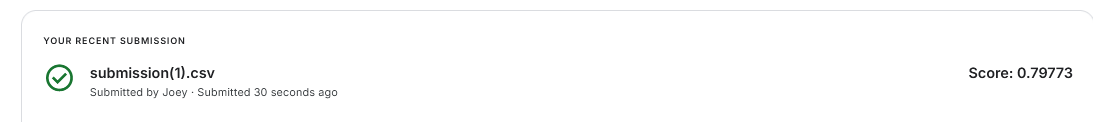